# Importing the libraries

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight')

In [2]:
# Configure API key 

quandl.ApiConfig.api_key = 'your kpi'

In [4]:
# Importing the Federal Reserve Economic Data "Youth Unemployment Rate for Norway" variable.
# I use the unemployment data because unemployment factor is known from literature to affect happiness. 
# I choose Norway as an example of happy country.

data = quandl.get('FRED/SLUEM1524ZSNOR')


In [5]:
data.head(5)

,Value
Date,
1991-01-01,12.609000
1992-01-01,13.668000
1993-01-01,13.712000
1994-01-01,12.447000
1995-01-01,18.971001


In [6]:
data.shape

(30, 1)

In [7]:
data.columns

Index(['Value'], dtype='object')

In [8]:
type(data)

pandas.core.frame.DataFrame

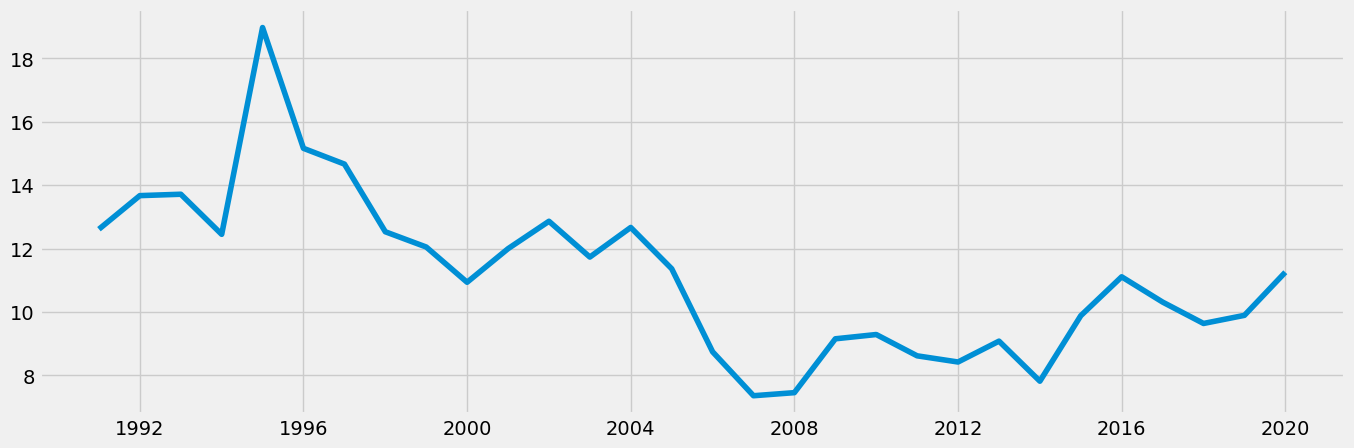

In [9]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data)

In [ ]:
# I am subsetting the data in order to have years relevant for the happiness score data.

In [10]:
data_2 = data.reset_index()

In [11]:
data_2.head()

,Date,Value
0,1991-01-01,12.609000
1,1992-01-01,13.668000
2,1993-01-01,13.712000
3,1994-01-01,12.447000
4,1995-01-01,18.971001


In [12]:
data_sub = data_2.loc[data_2['Date'] >= '2005-01-01']

In [13]:
data_sub.shape

(16, 2)

In [14]:
data_sub.head()

,Date,Value
14,2005-01-01,11.360
15,2006-01-01,8.741
16,2007-01-01,7.355
17,2008-01-01,7.452
18,2009-01-01,9.151


In [15]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
2005-01-01,11.360
2006-01-01,8.741
2007-01-01,7.355
2008-01-01,7.452
2009-01-01,9.151


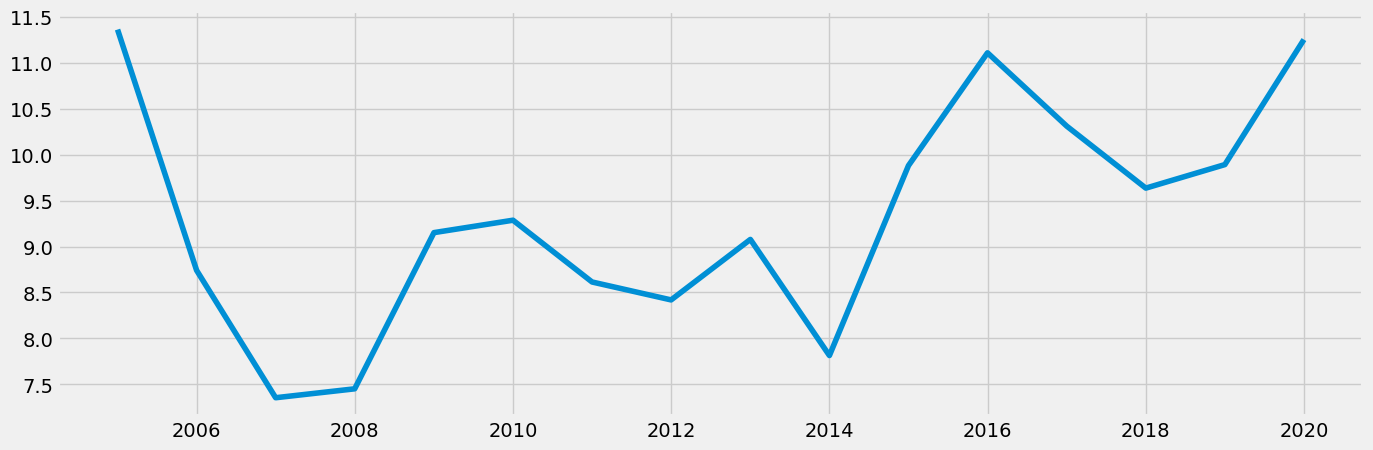

In [16]:
# Plot the new data set

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)


In [17]:
# Check for missing values (you shouldn't have any)

data_sub.isnull().sum() 

Value    0
dtype: int64

In [18]:
# Check for duplicates

dups = data_sub.duplicated()
dups.sum()

# No dups!

0

# Decomposition

In [19]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [20]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

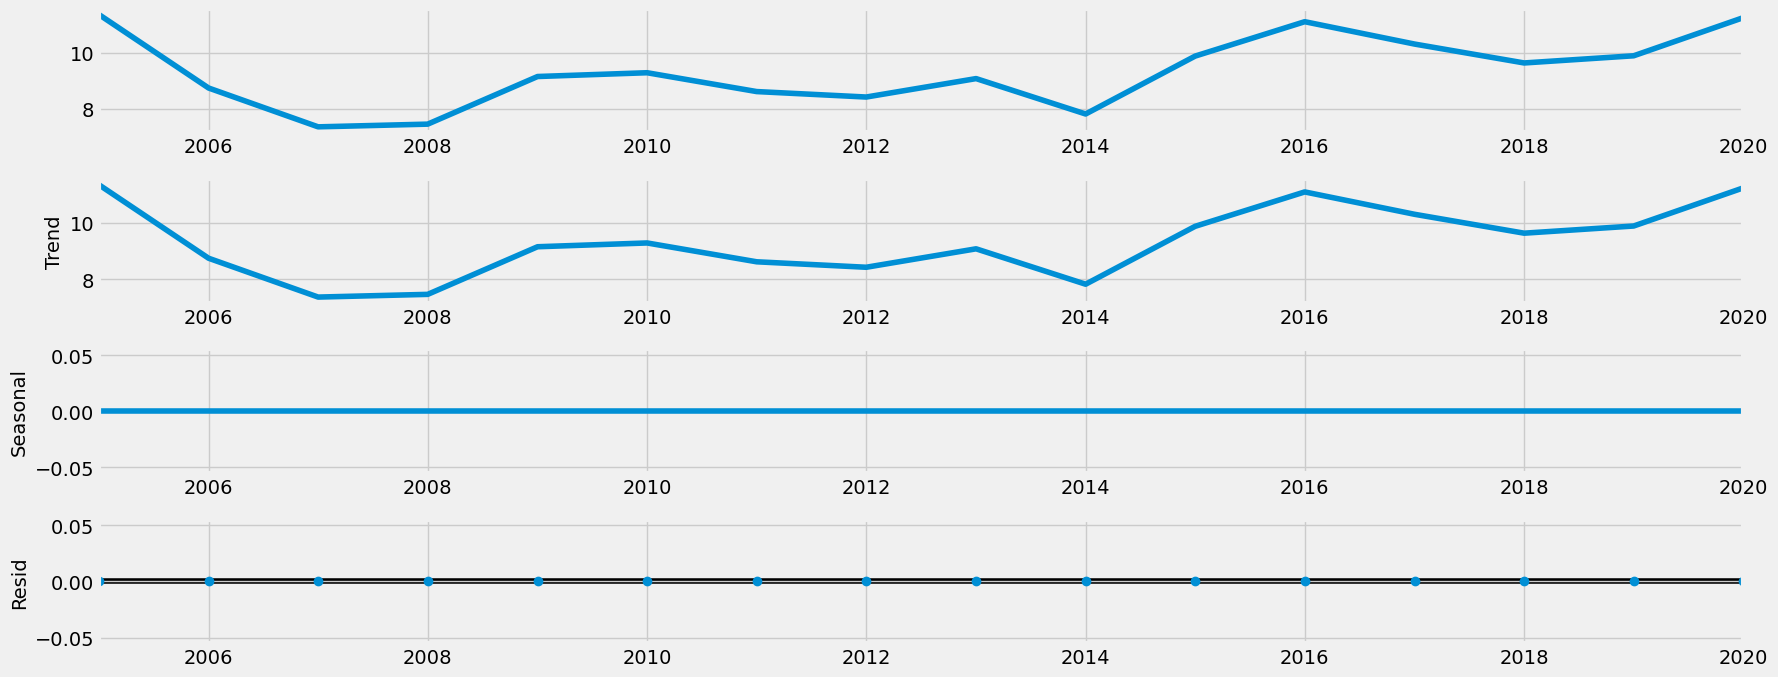

In [21]:
# Plot the separate components

decomposition.plot()
plt.show()

In [ ]:
# There is no obvious trend and no noise.
# As expected the data set shows no sesonality (annual data).

# Stationarity check

In [22]:
# The adfuller() function will import from the model from statsmodels for the test; however, running it will only return 
# an array of numbers. This is why you need to also define a function that prints the correct output from that array.

from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                 -2.335502
p-value                         0.160773
Number of Lags Used             0.000000
Number of Observations Used    15.000000
Critical Value (1%)            -3.964443
Critical Value (5%)            -3.084908
Critical Value (10%)           -2.681814
dtype: float64


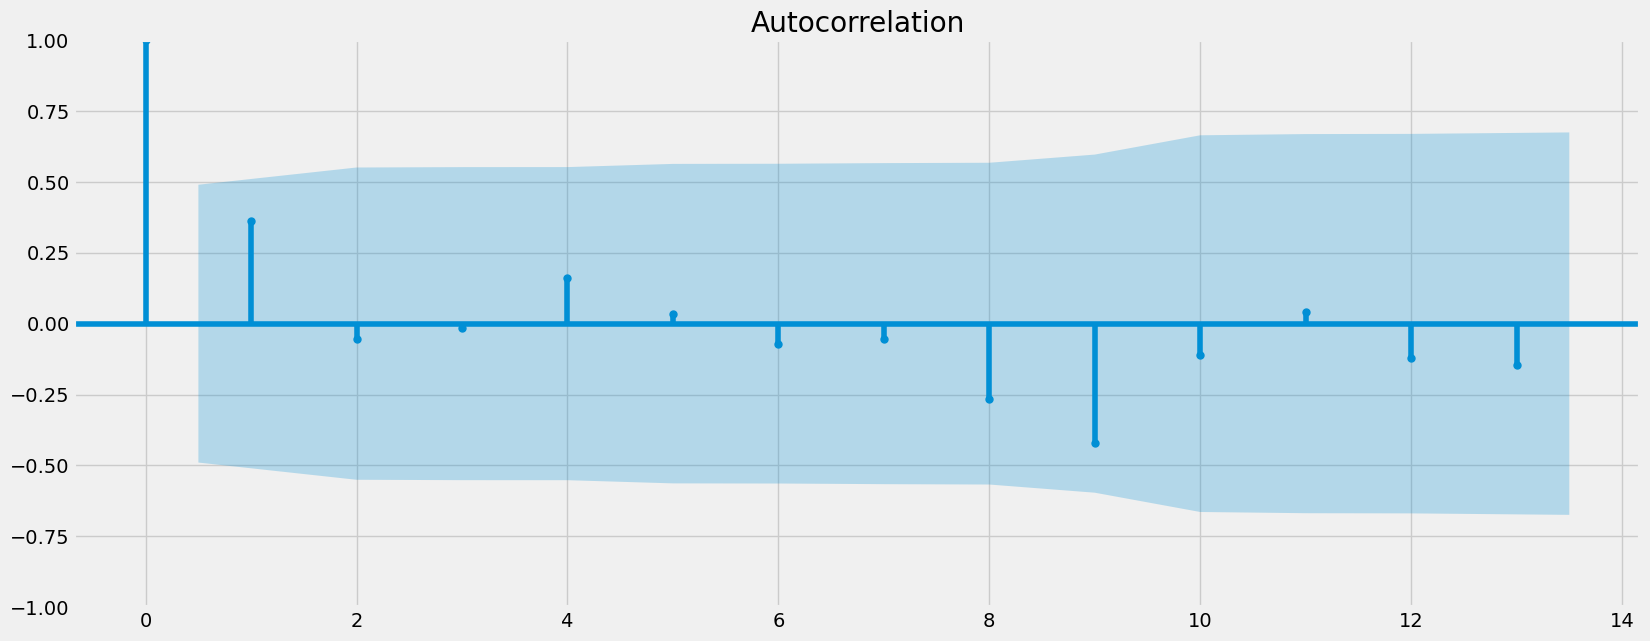

In [23]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

In [ ]:
# Dickey-Fuller p > 0.05 (0.16) and test statistic (-2.33) > critical values means that the data is stationary.

# Stationarizing

In [24]:
data_diff = data_sub - data_sub.shift(1)

In [25]:
data_diff.dropna(inplace = True)

In [26]:
data_diff.head()

,Value
datetime,
2006-01-01,-2.618999
2007-01-01,-1.386000
2008-01-01,0.097000
2009-01-01,1.699000
2010-01-01,0.135000


In [27]:
data_diff.columns

Index(['Value'], dtype='object')

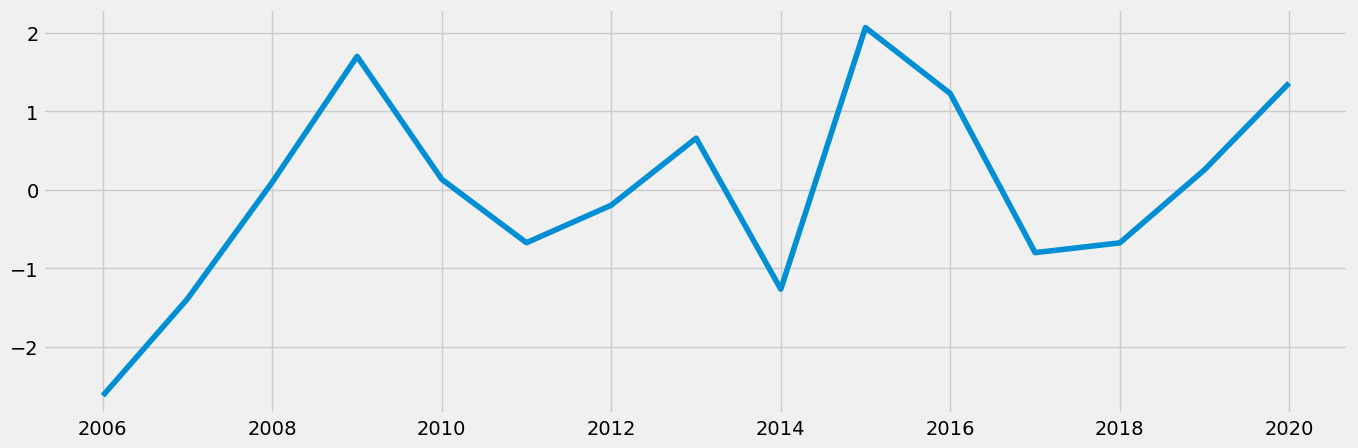

In [28]:
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [29]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -4.165840
p-value                         0.000752
Number of Lags Used             1.000000
Number of Observations Used    13.000000
Critical Value (1%)            -4.068854
Critical Value (5%)            -3.127149
Critical Value (10%)           -2.701730
dtype: float64


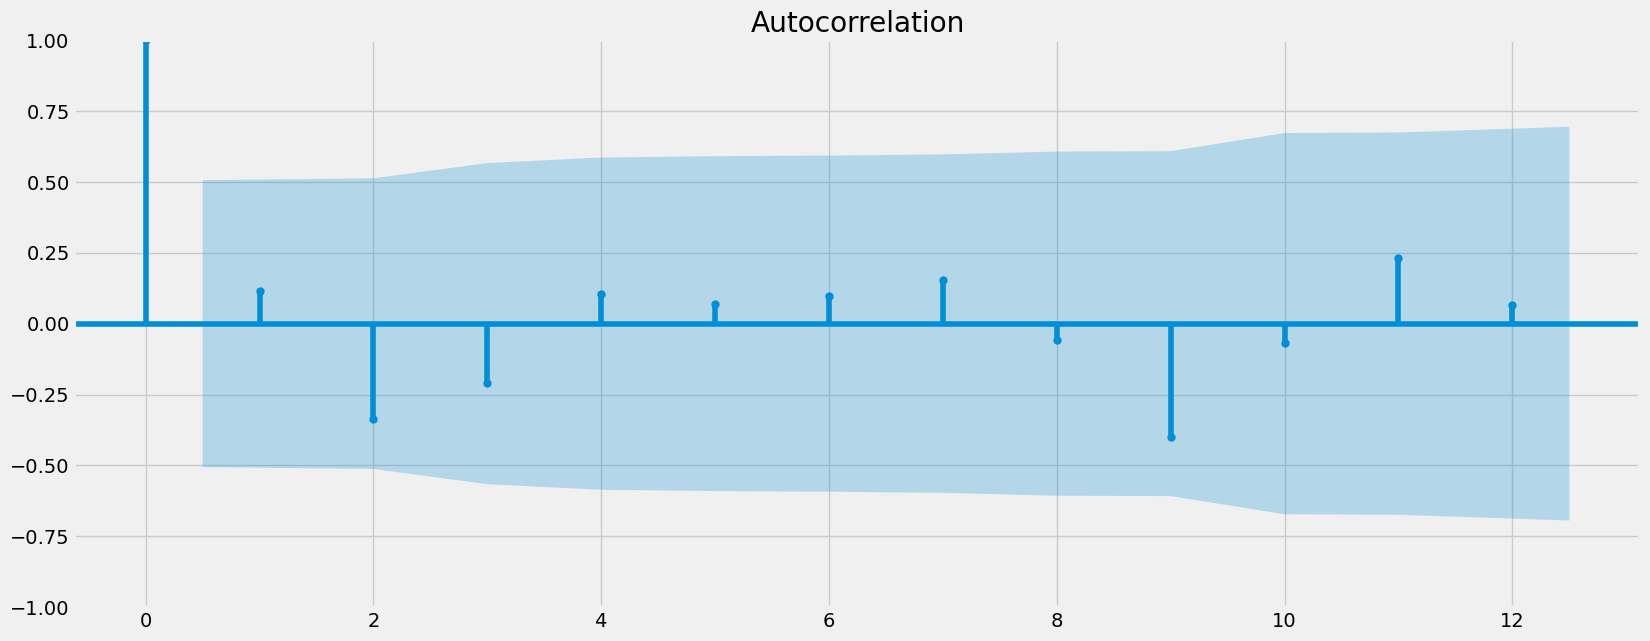

In [30]:
plot_acf(data_diff)
plt.show()

In [31]:
# Dickey-Fuller p < 0.005 and test statistic (-4.17) < critical values means that the data is not stationary.

In [32]:
# The autocorrelation test looks good. The stationarity of the data is strong.